# Pricing of European Call and Put Options with the COS Method

## Theory and Background

The COS method (Cosine expansion method) is an efficient technique for pricing options, particularly when the characteristic function of the underlying asset's price process is known analytically. This method is based on the Fourier-cosine series expansion and is known for its speed and accuracy.

The key idea is to approximate the density function of the underlying asset using a cosine series expansion. This approximation is then used to calculate the option price.

## Imports and Setup

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time


This block imports the necessary libraries:
- `numpy` for numerical computations
- `matplotlib.pyplot` for plotting
- `scipy.stats` for statistical functions
- `time` for measuring execution time

## Main Pricing Function


In [40]:
def callPutOptionsPriceCoSMthd(cf,Cp,S0,r,tau,K,N,L):
    # cf   - characteristic function as a functon, in the book denoted as \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # r    - interest rate (constant)
    # tau  - time to maturity
    # K    - list of strikes
    # N    - Number of expansion terms
    # L    - size of truncation domain (typ.:L=8 or L=10)

    # rehapse
    K=np.array(K).reshape([len(K),1])
    i=1j
    #turcation bounds
    x0=np.log(S0/K)
    a=0.0-L*np.sqrt(tau)
    b=0.0+L*np.sqrt(tau)
    #sumation from k=- to k=N-2
    k=np.linspace(0,N-1,N).reshape([N,1])
    u=k*np.pi/(b-a)
    #determing coiffesent for put price
    H_k=CallPutCoefficients(Cp,a,b,k)
    mat=np.exp(i*np.outer((x0-a),u))
    temp=cf(u)*H_k
    temp[0]=0.5*temp[0]
    value=np.exp(-r*tau)*K*np.real(mat@temp)
    return value

    


This function implements the core of the COS method for pricing European options. Here's a detailed breakdown:

1. **Input Parameters**:
   - `cf`: Characteristic function of the log-asset price process
   - `Cp`: Option type (Call or Put)
   - `S0`: Initial stock price
   - `r`: Risk-free interest rate
   - `tau`: Time to maturity
   - `K`: List of strike prices
   - `N`: Number of expansion terms
   - `L`: Size of the truncation domain

2. **Truncation Domain**:
   The method uses a truncated integration range [a, b], calculated as:
   ```
   a = 0 - L * sqrt(tau)
   b = 0 + L * sqrt(tau)
   ```
   where L is typically 8 or 10.

3. **Fourier Cosine Expansion**:
   The expansion uses N terms, with frequencies:
   ```
   u = k * pi / (b - a), for k = 0, 1, ..., N-1
   ```

4. **Option Price Calculation**:
   The option price V is approximated as:
   ```
   V ≈ exp(-r * tau) * K * Re(exp(i * (x0 - a) * u) * cf(u) * H_k)
   ```
   where:
   - `H_k` are coefficients depending on the payoff (calculated in `CallPutCoefficients`)
   - `cf(u)` is the characteristic function
   - `x0 = log(S0 / K)`

5. **Implementation Details**:
   - The function vectorizes calculations for efficiency.
   - The first term (k=0) is halved as per the COS method formula.

## Coefficient Calculation Function


In [47]:
def CallPutCoefficients(Cp,a,b,k):
    if str(Cp).lower()=='c' or str(Cp).lower()=="1":
        c=0.0
        d=b
        coef=Chi_Psi(a,b,c,d,k)
        Chi_k=coef['chi']
        Psi_k=coef['psi']
        if a<b and b <0.0:
            H_k=np.zeros([len(k),1])
        else:
            H_k=2.0/(b-a)*(Chi_k-Psi_k)
    elif str(Cp).lower()=="p" or str(Cp).lower()=="-1":
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    return H_k

    
            
            


This function calculates the coefficients `H_k` used in the COS method:

1. For Call options (Cp = 'c' or '1'):
   - Integration bounds: c = 0, d = b
   - `H_k = 2 / (b - a) * (Chi_k - Psi_k)` if b > 0, else `H_k = 0`

2. For Put options (Cp = 'p' or '-1'):
   - Integration bounds: c = a, d = 0
   - `H_k = 2 / (b - a) * (-Chi_k + Psi_k)`

The `Chi_k` and `Psi_k` values are calculated using the `Chi_Psi` function.

## Chi and Psi Calculation Function


In [48]:
def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value


This function calculates the `Chi_k` and `Psi_k` values used in the coefficient calculations:

1. `Psi_k` calculation:
   ```
   Psi_k = sin(k * pi * (d - a) / (b - a)) - sin(k * pi * (c - a) / (b - a))
   ```
   For k > 0, it's multiplied by `(b - a) / (k * pi)`.
   For k = 0, `Psi_0 = d - c`.

2. `Chi_k` calculation:
   ```
   Chi_k = 1 / (1 + (k * pi / (b - a))^2) * [expr1 + expr2]
   ```
   where:
   ```
   expr1 = cos(k * pi * (d - a) / (b - a)) * exp(d) - cos(k * pi * (c - a) / (b - a)) * exp(c)
   expr2 = k * pi / (b - a) * [sin(k * pi * (d - a) / (b - a)) - sin(k * pi * (c - a) / (b - a)) * exp(c)]
   ```

These calculations are derived from the Fourier-cosine expansion of the payoff function.

## Black-Scholes Formula for Comparison


In [49]:
def BS_call_options_price(Cp,S_0,K,sigma,tau,r):
    cp=str(Cp).lower()
    K=np.array(K).reshape([len(K),1])
    d1=(np.log(S_0/K)+(r+0.5*sigma**2)*tau)/(sigma*np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if Cp == "c" or Cp == "1":
        value = st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif Cp == "p" or Cp =="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0
    return value


This function implements the Black-Scholes formula for European options:

1. For Call options:
   ```
   C = N(d1) * S_0 - N(d2) * K * exp(-r * tau)
   ```

2. For Put options:
   ```
   P = N(-d2) * K * exp(-r * tau) - N(-d1) * S_0
   ```

Where:
- `N(x)` is the cumulative normal distribution function
- `d1 = (ln(S_0/K) + (r + 0.5 * sigma^2) * tau) / (sigma * sqrt(tau))`
- `d2 = d1 - sigma * sqrt(tau)`

This function is used to compare the results of the COS method with the analytical Black-Scholes prices.

## Main Calculation and Plotting


It took 0.00023981332778930665 seconds to price.
Abs error for strike 80 is equal to 1.31E-07
[20.79922618]
Abs error for strike 90 is equal to 3.93E-07
[11.13524273]
Abs error for strike 100 is equal to 3.87E-07
[3.65996807]
Abs error for strike 110 is equal to 4.32E-07
[0.5896157]
Abs error for strike 120 is equal to 3.50E-07
[0.04457746]


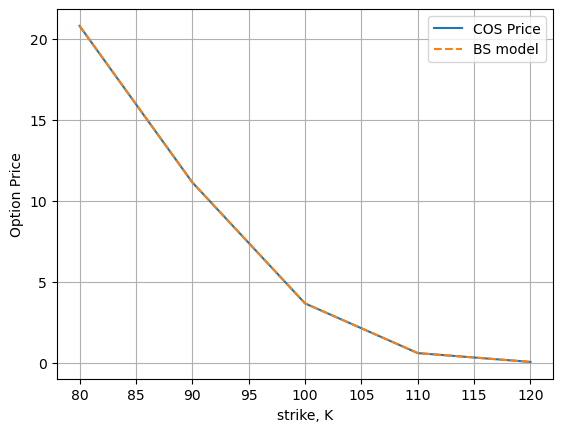

In [52]:
def mainCalculation():
    i = 1j
    
    Cp = "c"
    S0 = 100.0
    r = 0.1
    tau = 0.1
    sigma = 0.25
    K = [80, 90, 100, 110, 120]
    N = 4*32
    L = 10
    cf = lambda u: np.exp((r - 0.5 * np.power(sigma,2.0)) * i * u * tau - 0.5 * np.power(sigma, 2.0) * np.power(u, 2.0) * tau)
    NoOfIterations = 100
    time_start = time.time() 
    for k in range(0,NoOfIterations,1):
        val_COS = callPutOptionsPriceCoSMthd(cf,Cp,S0,r,tau,K,N,L)
    time_stop = time.time()
    print("It took {0} seconds to price.".format((time_stop-time_start)/float(NoOfIterations)))
    val_Exact = BS_call_options_price(Cp,S0,K,sigma,tau,r)
    plt.plot(K,val_COS)
    plt.plot(K,val_Exact,'--')
    plt.xlabel("strike, K")
    plt.ylabel("Option Price")
    plt.legend(["COS Price","BS model"])
    plt.grid()    
    # ERROR
    error = []
    for i in range(0,len(K)):
        error.append(np.abs(val_COS[i]-val_Exact[i])[0])
        print("Abs error for strike {0} is equal to {1:.2E}".format(K[i],error[i]))
        print(val_COS[i])
mainCalculation()


This function sets up the parameters, calculates option prices using both the COS method and Black-Scholes formula, and plots the results:

1. **Parameter Setup**:
   - Option type: Call
   - Initial stock price (S0): 100.0
   - Risk-free rate (r): 10%
   - Time to maturity (tau): 0.1 years
   - Volatility (sigma): 25%
   - Strike prices (K): 80, 90, 100, 110, 120
   - Number of expansion terms (N): 128
   - Truncation domain size (L): 10

2. **Characteristic Function**:
   For the Black-Scholes model:
   ```
   cf(u) = exp((r - 0.5 * sigma^2) * i * u * tau - 0.5 * sigma^2 * u^2 * tau)
   ```

3. **Calculations**:
   - COS method prices are calculated using `callPutOptionsPriceCoSMthd`
   - Black-Scholes prices are calculated using `BS_call_options_price`

4. **Performance Measurement**:
   The COS method calculation is repeated 100 times to measure average execution time.

5. **Plotting**:
   The function plots both COS and Black-Scholes prices against strike prices.

6. **Error Calculation**:
   The absolute error between COS and Black-Scholes prices is calculated and printed for each strike price.

This comprehensive setup allows for a detailed comparison of the COS method against the analytical Black-Scholes solution, demonstrating both the accuracy and efficiency of the COS method for option pricing.